# Hyperparameters space selection

This notebooks contains data exploratory analysis focused on properties that help to establish hyperparameters for selected clustering methods.

In [2]:
from pathlib import Path
from typing import Optional
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from IPython.display import display, Markdown
from pprint import pformat

## Loading data

In [3]:
from utils import load_gemler_data_normed

data, _ = load_gemler_data_normed()

If you installed Somoclu with pip on macOS, this typically means missing a linked library. If you compiled Somoclu with GCC, please make sure you have set DYLD_LIBRARY_PATH to include the GCC path. For more information, please refer to the documentation.


## Basic EDA

In [3]:
data.describe()

,1007_s_at,121_at,1405_i_at,1552257_a_at,1552348_at,1552365_at,1552426_a_at,1552610_a_at,1552615_at,1552621_at,...,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at
count,1545.000000,1545.000000,1545.000000,1545.000000,1545.000000,1545.000000,1545.000000,1545.000000,1545.000000,1545.000000,...,1545.000000,1545.000000,1545.000000,1545.000000,1545.000000,1545.000000,1545.000000,1545.000000,1545.000000,1545.000000
mean,0.198874,0.127230,0.042178,0.199069,0.012264,0.026556,0.193435,0.327234,0.084287,0.244526,...,0.007267,0.008827,0.007794,0.012073,0.011618,0.019583,0.017250,0.049390,0.042724,0.050131
std,0.085592,0.137739,0.056899,0.126746,0.050768,0.056945,0.076404,0.157951,0.059073,0.124659,...,0.025653,0.025888,0.025801,0.026049,0.026006,0.027218,0.026860,0.056088,0.052266,0.056779
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.144716,0.033857,0.010691,0.105996,0.001302,0.007011,0.144068,0.218347,0.050684,0.159927,...,0.003920,0.004085,0.003352,0.007120,0.006865,0.012025,0.010242,0.022967,0.016478,0.021957
50%,0.185825,0.057351,0.024532,0.166386,0.003921,0.011068,0.181480,0.309364,0.072449,0.224421,...,0.005909,0.007624,0.006535,0.010329,0.009963,0.017474,0.015375,0.040719,0.032975,0.040293
75%,0.239463,0.190959,0.050835,0.264439,0.008300,0.021204,0.226410,0.419630,0.101569,0.306404,...,0.008290,0.010582,0.009440,0.014000,0.013359,0.023388,0.020574,0.061265,0.054680,0.062697
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
from ydata_profiling import ProfileReport

In [5]:
data_profile = ProfileReport(
    data,
    minimal=True,
)

In [ ]:
data_profile.to_widgets()

## KMeans, KMedoids
* $k$ parameter search space will be selected here

In [36]:
from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score
from gap_statistic import OptimalK
from kneefinder import KneeFinder

KMEANS_K_VALUES = np.arange(2, 41, 1)


def tune_plots_kmeans_k(X: pd.DataFrame) -> Optional[KMeans]:
    """
    Method plotting Sum of Sqared Errors (SSE) and Silhouette scores for selected `k` values range.
    Shape of the plots helps to determine if a range of values is sufficient.
    """
    sse = []
    silhouette_scores = []
    for k in tqdm(KMEANS_K_VALUES, leave=False):
        sse.append(KMeans(n_clusters=k, n_init="auto").fit(X).inertia_)
        labels = KMeans(n_clusters=k, n_init="auto").fit_predict(X)
        silhouette_scores.append(silhouette_score(X, labels))

    _, ax = plt.subplots(3, 2, figsize=(10, 15))
    ax = ax.ravel()

    plt.suptitle("KMeans performance")

    ax[0].plot(KMEANS_K_VALUES, sse)
    kf = KneeFinder(KMEANS_K_VALUES, sse)
    knee_x, knee_y = kf.find_knee()
    ax[0].plot([knee_x, knee_x], [min(sse), max(sse)], '--', label=f"Knee at {knee_x, knee_y}")
    ax[0].set_xlabel("k values")
    ax[0].set_ylabel("Sum of Squared Errors")

    ax[1].plot(KMEANS_K_VALUES, silhouette_scores)
    kf = KneeFinder(KMEANS_K_VALUES, silhouette_scores)
    knee_x, knee_y = kf.find_knee()
    ax[1].plot([knee_x, knee_x], [min(silhouette_scores), max(silhouette_scores)], '--', label=f"Knee at {knee_x, knee_y}")
    ax[1].set_xlabel("k values")
    ax[1].set_ylabel("Silhouette score")

    optimal_k = OptimalK(n_jobs=-1, parallel_backend="joblib", n_iter=20, clusterer_kwargs=dict(iter=1, minit="++"))
    _ = optimal_k(data, cluster_array=KMEANS_K_VALUES)

    ax[2].plot(optimal_k.gap_df.n_clusters, optimal_k.gap_df.gap_value)
    max_gap = optimal_k.gap_df.gap_value.max()
    max_gap_ind = optimal_k.gap_df.gap_value.argmax()
    max_gap_n = optimal_k.gap_df.n_clusters[max_gap_ind]
    ax[2].plot(max_gap_n, max_gap, "o")
    ax[2].annotate(
        int(max_gap_n),
        (max_gap_n, max_gap),
        (max_gap_n - 2, max_gap + 0.005),
    )
    ax[2].set_xlabel("k values")
    ax[2].set_ylabel("Gap statistic")

    ax[3].plot(optimal_k.gap_df.n_clusters, optimal_k.gap_df.loc[:, "gap*"])
    max_gap = optimal_k.gap_df.loc[:, "gap*"].max()
    max_gap_ind = optimal_k.gap_df.loc[:, "gap*"].argmax()
    max_gap_n = optimal_k.gap_df.n_clusters[max_gap_ind]
    ax[3].plot(max_gap_n, max_gap, "o")
    ax[3].annotate(
        int(max_gap_n),
        (max_gap_n, max_gap),
        (max_gap_n - 2, max_gap + 0.005),
    )
    ax[3].set_xlabel("k values")
    ax[3].set_ylabel("Gap* statistic")

    ax[4].plot(optimal_k.gap_df.n_clusters, optimal_k.gap_df.loc[:, "diff"])
    pos_diff_ind = optimal_k.gap_df.loc[:, "diff"] > 0
    pos_diff = optimal_k.gap_df.loc[:, "diff"]
    pos_diff_n = optimal_k.gap_df.n_clusters[pos_diff_ind]
    for d, n in zip(pos_diff, pos_diff_n):
        ax[4].scatter(n, d, marker="o")
        ax[4].annotate(
            int(n),
            (n, d),
            (n + 2, d + 0.005),
        )
    ax[4].set_xlabel("k values")
    ax[4].set_ylabel("diff = Gap(k) - Gap(k+1) + s(k+1)")

    ax[5].plot(optimal_k.gap_df.n_clusters, optimal_k.gap_df.loc[:, "diff*"])
    pos_diff_ind = optimal_k.gap_df.loc[:, "diff*"] > 0
    pos_diff = optimal_k.gap_df.loc[pos_diff_ind, "diff*"]
    pos_diff_n = optimal_k.gap_df.n_clusters[pos_diff_ind]
    for d, n in zip(pos_diff, pos_diff_n):
        ax[5].scatter(n, d, marker="o")
        ax[5].annotate(
            int(n),
            (n, d),
            (n + 2, d + 0.005),
        )
    ax[5].set_xlabel("k values")
    ax[5].set_ylabel("diff* = Gap*(k) - Gap*(k+1) + s*(k+1)")

    plt.tight_layout()
    plt.show()

    display(optimal_k.gap_df)


  0%|          | 0/39 [00:00<?, ?it/s]

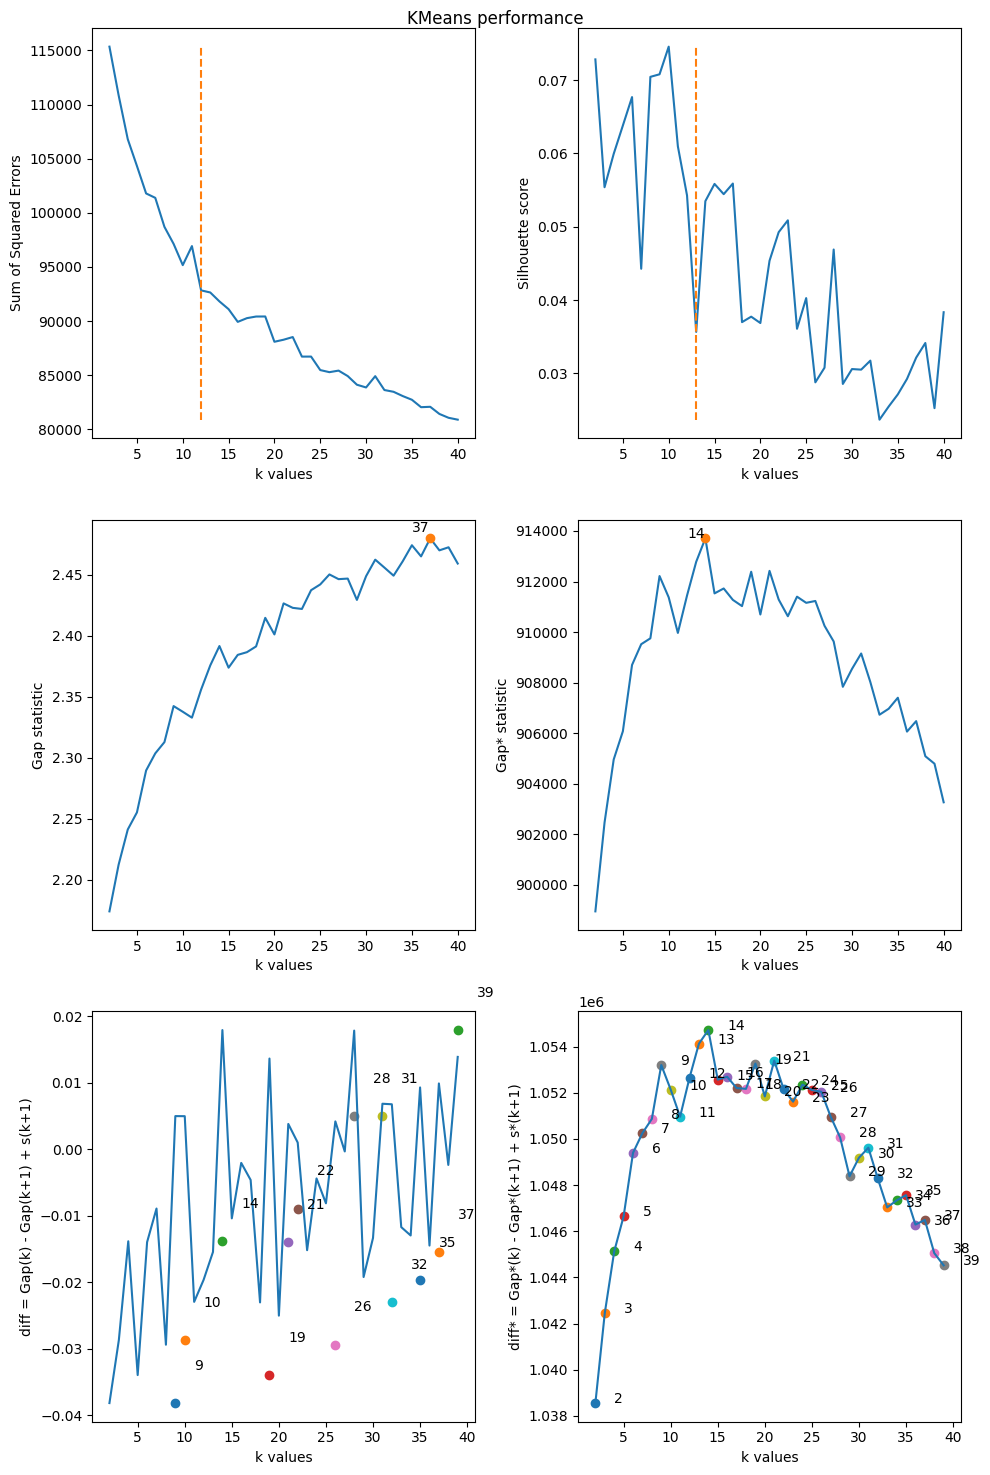

,n_clusters,gap_value,ref_dispersion_std,sk,gap*,sk*,diff,diff*
0,2.0,2.173993,242.220128,0.000276,898940.443117,1.038007e+06,-0.038139,1.038551e+06
1,3.0,2.212229,84.079814,0.000096,902455.771202,1.042066e+06,-0.028659,1.042453e+06
2,4.0,2.241116,200.163818,0.000228,904954.147135,1.044951e+06,-0.013828,1.045124e+06
3,5.0,2.255135,167.754169,0.000191,906071.068566,1.046241e+06,-0.033931,1.046647e+06
4,6.0,2.289497,377.184530,0.000431,908696.283305,1.049272e+06,-0.013956,1.049399e+06
5,7.0,2.303532,69.260016,0.000079,909517.906391,1.050221e+06,-0.008909,1.050257e+06
6,8.0,2.312765,283.323781,0.000324,909750.573030,1.050490e+06,-0.029372,1.050871e+06
7,9.0,2.342299,141.750442,0.000162,912215.903045,1.053336e+06,0.004979,1.053206e+06
8,10.0,2.337659,295.586893,0.000338,911372.329468,1.052362e+06,0.004965,1.052144e+06
9,11.0,2.332808,99.755972,0.000114,909964.471120,1.050736e+06,-0.022934,1.050965e+06


In [37]:
tune_plots_kmeans_k(data)

In [38]:
KMEANS_K_VALUES = np.arange(2, 15, 1)
display(Markdown(f"\n```python\nKMEANS_K_VALUES = {pformat(list(KMEANS_K_VALUES))}\n```"))


```python
KMEANS_K_VALUES = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
```

## BIRCH
Parameters to evaluate:
* `threshold` - the upper limit of subcluster's radius. 10 values from the range between minimum and maximum distance between samples will be selected.
* `branching_factor` - maximum number of CF Tree node's sublclusters. This will be simply 5 values sampled from the range `[5, 100)`.
* `n_clusters` - _this will be based on the range selected for KMeans algorithm_

In [20]:
from sklearn.metrics.pairwise import euclidean_distances
dist_matrix = euclidean_distances(data)
min_dist = dist_matrix.min()
max_dist = dist_matrix.max()
display(Markdown(f"For `threshold` 10 values from range `({min_dist}, {max_dist})` will be selected."))

For `threshold` 10 values from range `(0.0, 25.518847840970015)` will be selected.

In [21]:
BIRCH_THRESHOLD_VALUES = np.linspace(min_dist, max_dist, num=11)[1:]
display(Markdown(f"\n```python\nBIRCH_THRESHOLD_VALUES = {pformat(list(BIRCH_THRESHOLD_VALUES)+[None])}\n```"))


```python
BIRCH_THRESHOLD_VALUES = [2.5518847840970014,
 5.103769568194003,
 7.655654352291004,
 10.207539136388005,
 12.759423920485007,
 15.311308704582007,
 17.86319348867901,
 20.41507827277601,
 22.966963056873013,
 25.518847840970015,
 None]
```

In [22]:
BIRCH_BRANCHING_FACTOR_VALUES = np.linspace(5, 100, num=5, dtype=int)
display(Markdown(f"\n```python\nBIRCH_BRANCHING_FACTOR_VALUES = {pformat(list(BIRCH_BRANCHING_FACTOR_VALUES))}\n```"))


```python
BIRCH_BRANCHING_FACTOR_VALUES = [5, 28, 52, 76, 100]
```

## Affinity propagation
Parameters to evaluate:
* `damping` - extent to which the current value is maintained relative to incoming values (from range `[0.5, 1)`, so 5 values will be sampled from this range)
* `preference` - preference of points, it influences number of exemplars (so also clusters), that will be chosen. Default value is a median of input similarities. Therefore, additionally to median, 10 values from the range selected on this median value will be chosen.

In [23]:
AFFINITY_PROP_DUMPING_VALUES = np.arange(0.5, 1, 0.1)
display(Markdown(f"\n```python\nAFFINITY_PROP_DUMPING_VALUES = {pformat(list(AFFINITY_PROP_DUMPING_VALUES))}\n```"))


```python
AFFINITY_PROP_DUMPING_VALUES = [0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999]
```

In [24]:
from sklearn.metrics import pairwise_distances
similarity_matrix = -pairwise_distances(data, metric="sqeuclidean")
display(Markdown(f"Median of similarities (default `preference` value): {np.median(similarity_matrix)}"))

Median of similarities (default `preference` value): -155.27094426756443

In [25]:
AFFINITY_PROP_PREFERENCE_VALUES = np.linspace(2*np.median(similarity_matrix), 0, num=10)
display(Markdown(f"\n```python\nAFFINITY_PROP_PREFERENCE_VALUES = {pformat(list(AFFINITY_PROP_PREFERENCE_VALUES))}\n```"))


```python
AFFINITY_PROP_PREFERENCE_VALUES = [-310.54188853512886,
 -276.0372342534479,
 -241.5325799717669,
 -207.0279256900859,
 -172.52327140840492,
 -138.01861712672394,
 -103.51396284504295,
 -69.00930856336197,
 -34.504654281680985,
 0.0]
```

## DBSCAN
Pameters to evaluate:
* `eps` - the radius of sample's neighborhood
* `min_samples` - minimum number of neighboring samples of a particular sample to consider it a _core point_

Starting poinst for exploration will be determined using approach described in the paper:
```
@inproceedings{rahmah2016determination,
  title={Determination of optimal epsilon (eps) value on dbscan algorithm to clustering data on peatland hotspots in sumatra},
  author={Rahmah, Nadia and Sitanggang, Imas Sukaesih},
  booktitle={IOP conference series: earth and environmental science},
  volume={31},
  number={1},
  pages={012012},
  year={2016},
  organization={IoP Publishing}
}
```

For `min_samples` estimations popular rules of thumb are `num_features+1` or `num_features*2`, however in case of genomic data it is imposible to apply, due to much higher number of dimensions than samples. Therefore a `min_samples` will be gridsearched from range `[5, num_samples/4)`. Ten values will be uniformly selected from this range and for each value a proper epsilon value will be selected.

In [31]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors


MIN_SAMPLES_VALUES = np.linspace(5, data.shape[0]/4, num=10, dtype=int)

def tune_dbscan(X: pd.DataFrame, min_samples: int, ax: Optional[plt.Axes]=None) -> Optional[DBSCAN]:
    # tune epsilon with estimation based on NN
    k = min_samples - 1
    nns = NearestNeighbors(n_neighbors=k).fit(X)
    distances, _ = nns.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:, k - 1]

    ax = ax if ax is not None else plt.gca()
    ax.plot(distances)
    kf = KneeFinder(range(0, len(distances)), distances)
    knee_x, knee_y = kf.find_knee()
    ax.plot([0, len(distances)], [knee_y, knee_y], '--', label=f"Knee at {knee_x, knee_y}")
    ax.set_title(f"Distance Curve (of KNN) for {min_samples}")
    ax.set_ylabel("Distance threshold (epsilon)")
    ax.legend()
    return knee_y # found eps value

In [32]:
MIN_SAMPLES_VALUES
display(Markdown(f"\n```python\nMIN_SAMPLES_VALUES = {pformat(list(MIN_SAMPLES_VALUES))}\n```"))


```python
MIN_SAMPLES_VALUES = [5, 47, 89, 132, 174, 216, 259, 301, 343, 386]
```

/var/folders/_h/6ffwq3jn4g94mt887zqcgpth0000gn/T/ipykernel_1380/428225744.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


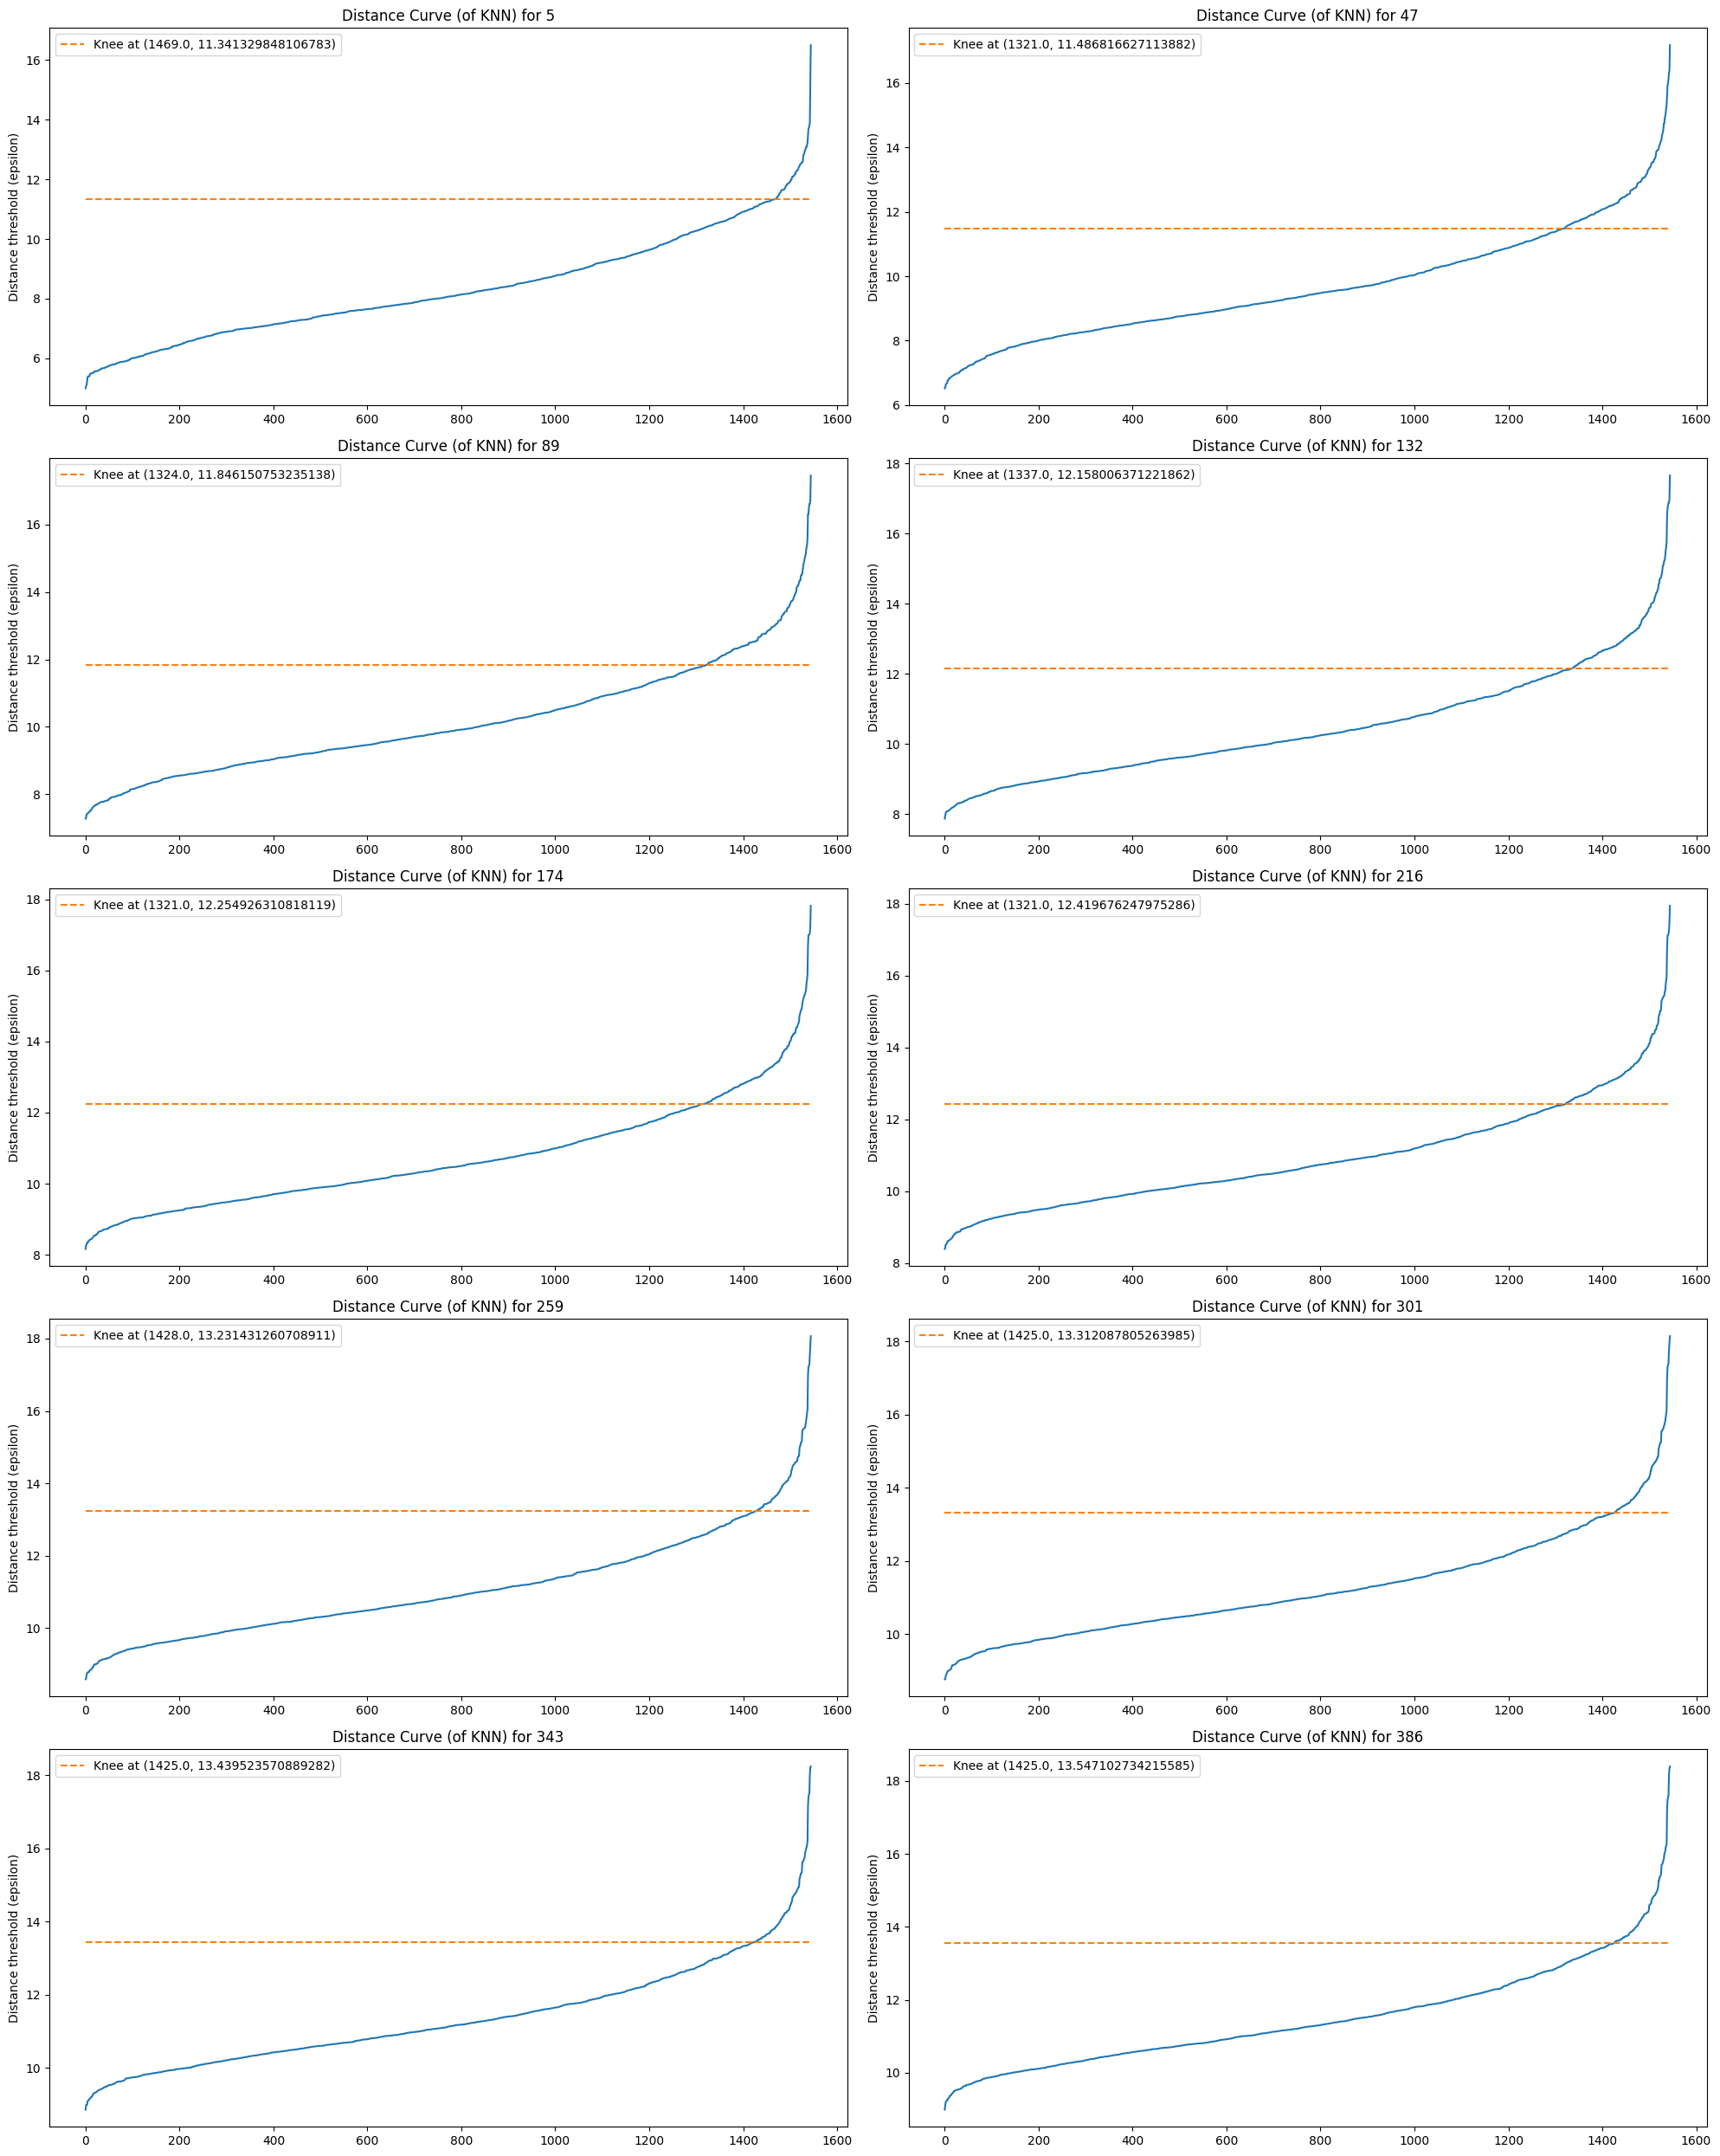

In [33]:
found_eps_values = []
ncols = 2
nrows = int(np.ceil(len(MIN_SAMPLES_VALUES) / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(10*ncols, 5*nrows))
axs = np.ravel(axs)
for min_samples, ax in zip(MIN_SAMPLES_VALUES, axs):
    found_eps_values.append(tune_dbscan(data, min_samples, ax))
fig.tight_layout()
fig.show()

In [35]:
EPS_VALUES = found_eps_values
display(Markdown(f"\n```python\nEPS_VALUES = {pformat(list(EPS_VALUES))}\n```"))


```python
EPS_VALUES = [11.341329848106783,
 11.486816627113882,
 11.846150753235138,
 12.158006371221862,
 12.254926310818119,
 12.419676247975286,
 13.231431260708911,
 13.312087805263985,
 13.439523570889282,
 13.547102734215585]
```

## OPTICS
This method is used as an improvement of DBSCAN (`cluster_method="dbscan"`), therefore only `min_samples` parameter needs to be provided and it can be copied from the values estimated for DBSCAN.

## Gaussian Mixtures
Parameters to evaluate:
* `n_components` - number of mixture components (It will be copied from $k$ value established for KMeans)

## SOM
Paramters to evaluate:
* `n_rows` / `n_cols` - number of neurons in the row / col of som grid (2D map is used). It will be copied from KMeans $k$ value, but with additional `1` value, so there could be a map which is 1D as well. So the number of clusters matches previously selected `k` space, there will be rule `n_rows * n_cols <= max(K_VALUES)`.
* `initialcodebook` & `neighborhood` - values available in the library will be used

In [41]:
from itertools import product

display(
    Markdown(
        f"\n```python\nN_COLS_N_ROWS_PAIRS = {pformat([(k1, k2) for k1, k2 in product([1] + list(KMEANS_K_VALUES), list(KMEANS_K_VALUES)) if k1 * k2 <= max(KMEANS_K_VALUES)])}\n```"
    )
)



```python
N_COLS_N_ROWS_PAIRS = [(1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 2),
 (4, 3),
 (5, 2),
 (6, 2),
 (7, 2)]
```